Andi Nur Salsabila

In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pathlib

In [2]:
# mengakses kaggle
os.environ['KAGGLE_USERNAME'] = "andinursalsabila"
os.environ['KAGGLE_KEY'] = "32050edd6e02f12f21dd3a78eaaba64e"

# copy API command dataset untuk mendownloadnya
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

100% 3.57G/3.58G [00:23<00:00, 187MB/s]
100% 3.58G/3.58G [00:23<00:00, 166MB/s]


In [3]:
import os
import zipfile

local_zip = '/content/fruits-fresh-and-rotten-for-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

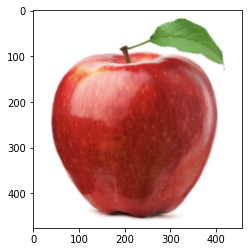

In [5]:
img = tf.keras.utils.load_img('/content/dataset/dataset/train/freshapples/Screen Shot 2018-06-08 at 4.59.36 PM.png')
imgplot = plt.imshow(img)

In [19]:
#Augmentasi Gambar
from tensorflow.keras.preprocessing.image import ImageDataGenerator
     
train_dir = os.path.join('/content/dataset/dataset/train')
test_dir = os.path.join('/content/dataset/dataset/test')

train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        shear_range=0.2,
        fill_mode = 'wrap')
validation_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
#Data Generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
        test_dir, 
        target_size=(150, 150),
        class_mode='categorical')

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [21]:
import tensorflow as tf
model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),  
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')  
])

In [22]:
model.compile(optimizer=tf.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nAkurasi telah mencapai >98%!")
      self.model.stop_training = True
callbacks = myCallback()

In [24]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    verbose=2,
                    batch_size=1000,
                    callbacks=[callbacks])

Epoch 1/50
341/341 - 102s - loss: 0.7473 - accuracy: 0.7189 - val_loss: 0.4138 - val_accuracy: 0.8551 - 102s/epoch - 298ms/step
Epoch 2/50
341/341 - 100s - loss: 0.3704 - accuracy: 0.8658 - val_loss: 0.2925 - val_accuracy: 0.9062 - 100s/epoch - 293ms/step
Epoch 3/50
341/341 - 100s - loss: 0.2621 - accuracy: 0.9037 - val_loss: 0.1918 - val_accuracy: 0.9348 - 100s/epoch - 292ms/step
Epoch 4/50
341/341 - 99s - loss: 0.2224 - accuracy: 0.9162 - val_loss: 0.1728 - val_accuracy: 0.9337 - 99s/epoch - 290ms/step
Epoch 5/50
341/341 - 100s - loss: 0.1670 - accuracy: 0.9374 - val_loss: 0.1381 - val_accuracy: 0.9574 - 100s/epoch - 292ms/step
Epoch 6/50
341/341 - 99s - loss: 0.1535 - accuracy: 0.9449 - val_loss: 0.1387 - val_accuracy: 0.9577 - 99s/epoch - 290ms/step
Epoch 7/50
341/341 - 100s - loss: 0.1295 - accuracy: 0.9520 - val_loss: 0.2820 - val_accuracy: 0.9170 - 100s/epoch - 293ms/step
Epoch 8/50
341/341 - 99s - loss: 0.1264 - accuracy: 0.9561 - val_loss: 0.1143 - val_accuracy: 0.9615 - 99s/e

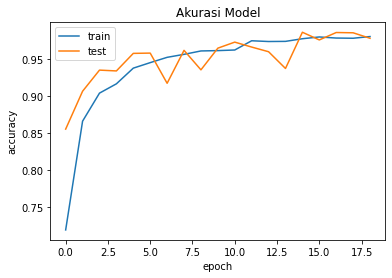

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

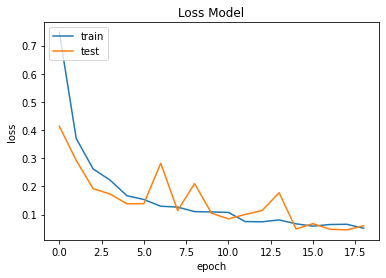

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
#Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

#Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

38572844